In [2]:
import numpy as np
import pandas as pd
import os
import random
import math
import tqdm
import copy
import ast
from itertools import chain, combinations
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
# PRNG seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

In [4]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Loading the dataset

In [5]:
# Change working directory to 'spambase'
os.chdir('spambase')  # Replace with the actual path
print("Current Directory:", os.getcwd())

Current Directory: /Users/abbaszal/Desktop/thesis/Spam base dataset/spambase


In [6]:
df = pd.read_csv('spambase.data' , header=None)

Preprocessing

In [7]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The model accuracy without clients:

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

acc = model.score(X_test, y_test)
print(acc)

0.9196525515743756


In [9]:
# Function to find best and worst clients based on local accuracies list
def find_best_worst_clients(client_local_accuracies):
    if not client_local_accuracies:
        print("The client local accuracies list is empty.")
        return None, None

    # Find the index of the best and worst clients
    best_client = max(range(len(client_local_accuracies)), key=lambda i: client_local_accuracies[i]) + 1
    worst_client = min(range(len(client_local_accuracies)), key=lambda i: client_local_accuracies[i]) + 1

    print(f"Best Client: {best_client}, Worst Client: {worst_client}")
    return best_client, worst_client








# Function to calculate mean global accuracy with/without specific client
def calculate_global_accuracy(df_results, client_id):

 
    with_client = df_results[df_results['Clients'].apply(lambda x: client_id in x)]
    without_client = df_results[df_results['Clients'].apply(lambda x: client_id not in x)]

 
    if not with_client.empty:
        mean_with_client = with_client['Global Accuracy'].mean()
        std_with_client = with_client['Global Accuracy'].std()
        min_with_client = with_client['Global Accuracy'].min()
        max_with_client = with_client['Global Accuracy'].max()
    else:
        mean_with_client = std_with_client = min_with_client = max_with_client = None


    if not without_client.empty:
        mean_without_client = without_client['Global Accuracy'].mean()
        std_without_client = without_client['Global Accuracy'].std()
        min_without_client = without_client['Global Accuracy'].min()
        max_without_client = without_client['Global Accuracy'].max()
    else:
        mean_without_client = std_without_client = min_without_client = max_without_client = None

    print(f"Statistics of Global Accuracy with Client {client_id}:")
    print(f"  Mean: {mean_with_client}")
    print(f"  Std Dev: {std_with_client}")
    print(f"  Min: {min_with_client}")
    print(f"  Max: {max_with_client}")

    print(f"\nStatistics of Global Accuracy without Client {client_id}:")
    print(f"  Mean: {mean_without_client}")
    print(f"  Std Dev: {std_without_client}")
    print(f"  Min: {min_without_client}")
    print(f"  Max: {max_without_client}")

  
    return {
        'with_client': {
            'mean': mean_with_client,
            'std': std_with_client,
            'min': min_with_client,
            'max': max_with_client,
            'data': with_client['Global Accuracy']
        },
        'without_client': {
            'mean': mean_without_client,
            'std': std_without_client,
            'min': min_without_client,
            'max': max_without_client,
            'data': without_client['Global Accuracy']
        }
    }











# Function to find the best global accuracy per client
def find_best_global_accuracy_per_client(df_results):

    best_global_accuracy_per_client = {}
    
    for client_idx in range(1, len(df_results.columns) - 2):
        with_client_rows = df_results[df_results['Clients'].apply(lambda x: client_idx in x)]
        if not with_client_rows.empty:
            best_row = with_client_rows.loc[with_client_rows['Global Accuracy'].idxmax()]
            best_global_accuracy_per_client[client_idx] = {
                "Best Global Accuracy": best_row['Global Accuracy'],
                "Best Combination": best_row['Clients']
            }
        else:
            print(f"No rows found for client {client_idx}.")

    if best_global_accuracy_per_client:
        df_best_global_per_client = pd.DataFrame.from_dict(best_global_accuracy_per_client, orient='index')
        df_best_global_per_client.index.name = "Client"
        df_best_global_per_client.reset_index(inplace=True)
        print("Best Global Accuracy per Client:\n", df_best_global_per_client)
        return df_best_global_per_client
    else:
        print("No best global accuracy data found.")
        return pd.DataFrame()
    
def find_worst_global_accuracy_per_client(df_results):

    worst_global_accuracy_per_client = {}
    
    for client_idx in range(1, len(df_results.columns) - 2):
        with_client_rows = df_results[df_results['Clients'].apply(lambda x: client_idx in x)]
        if not with_client_rows.empty:
            worst_row = with_client_rows.loc[with_client_rows['Global Accuracy'].idxmin()]
            worst_global_accuracy_per_client[client_idx] = {
                "Worst Global Accuracy": worst_row['Global Accuracy'],
                "Worst Combination": worst_row['Clients']
            }
        else:
            print(f"No rows found for client {client_idx}.")

    if worst_global_accuracy_per_client:
        df_worst_global_per_client = pd.DataFrame.from_dict(worst_global_accuracy_per_client, orient='index')
        df_worst_global_per_client.index.name = "Client"
        df_worst_global_per_client.reset_index(inplace=True)
        print("Worst Global Accuracy per Client:\n", df_worst_global_per_client)
        return df_worst_global_per_client
    else:
        print("No worst global accuracy data found.")
        return pd.DataFrame()


# Function to calculate client contributions to best/worst combinations
def calculate_client_contributions(df_results, best=True):

    combinations = []
    for client_idx in range(1, len(df_results.columns) - 2):
        with_client_rows = df_results[df_results['Clients'].apply(lambda x: client_idx in x)]
        if not with_client_rows.empty:
            row = with_client_rows.loc[with_client_rows['Global Accuracy'].idxmax() if best else with_client_rows['Global Accuracy'].idxmin()]
            combinations.append((row['Clients']))
        else:
            print(f"No rows found for client {client_idx}.")

    if combinations:
        flattened_combinations = sum(combinations, [])
        client_counts = Counter(flattened_combinations)
        client_contribution_df = pd.DataFrame(client_counts.items(), columns=['Client', 'Frequency'])
        client_contribution_df.sort_values(by='Frequency', ascending=False, inplace=True)
        print("Client Contributions:\n", client_contribution_df)
        return client_contribution_df
    else:
        print("No valid combinations found.")
        return pd.DataFrame()









# Function to visualize client contributions
def visualize_client_contributions(client_contribution_df, title):
    """
    Visualizes client contributions using a bar chart.
    """
    plt.bar(client_contribution_df['Client'], client_contribution_df['Frequency'])
    plt.xlabel('Client')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Function to analyze worst combinations
def analyze_worst_combinations(df_results):
    """
    Analyzes the worst combinations for each client based on global accuracy.
    """
    worst_combinations = []
    for client_idx in range(1, len(df_results.columns) - 2):
        with_client_rows = df_results[df_results['Clients'].apply(lambda x: client_idx in x)]
        if not with_client_rows.empty:
            worst_row = with_client_rows.loc[with_client_rows['Global Accuracy'].idxmin()]
            worst_combinations.append((worst_row['Clients']))
        else:
            print(f"No rows found for client {client_idx}.")

    if worst_combinations:
        flattened_worst_combinations = sum(worst_combinations, [])
        client_worst_counts = Counter(flattened_worst_combinations)
        client_worst_contribution_df = pd.DataFrame(client_worst_counts.items(), columns=['Client', 'Frequency'])
        client_worst_contribution_df.sort_values(by='Frequency', ascending=False, inplace=True)

        print("\nClient Contribution to Worst Combinations:\n", client_worst_contribution_df)
        plt.bar(client_worst_contribution_df['Client'], client_worst_contribution_df['Frequency'])
        plt.xlabel('Client')
        plt.ylabel('Frequency in Worst Combinations')
        plt.title('Client Contribution to Worst Combinations')
        plt.show()

        return client_worst_contribution_df
    else:
        print("No worst combinations found.")
        return pd.DataFrame()










def compute_and_visualize_shapley_values(  df_results ,  client_local_accuracies,  n_clients=10):


    # Create a mapping from subset to global accuracy
    subset_value = defaultdict(float)
    for index, row in df_results.iterrows():
        clients_included = (row['Clients'])  # List of client indices (1-based)
        global_accuracy = row['Global Accuracy']

        # Convert to 0-based indices and create a frozenset
        subset = frozenset([client - 1 for client in clients_included])
        subset_value[subset] = global_accuracy

    # Generate all possible subsets of clients
    all_subsets = []
    for k in range(n_clients + 1):
        for subset in combinations(range(n_clients), k):
            all_subsets.append(frozenset(subset))

    # Precompute factorials for efficiency
    factorials = [math.factorial(k) for k in range(n_clients + 1)]
    n_factorial = factorials[n_clients]

    # Initialize Shapley values
    shapley_values = np.zeros(n_clients)

    # Compute Shapley values for each client
    for i in range(n_clients):
        shapley_value_i = 0.0
        for S in all_subsets:
            if i not in S:
                S_union_i = S.union({i})
                v_S = subset_value.get(S, 0)
                v_S_union_i = subset_value.get(S_union_i, 0)
                weight = (factorials[len(S)] * factorials[n_clients - len(S) - 1]) / n_factorial
                marginal_contribution = v_S_union_i - v_S
                shapley_value_i += weight * marginal_contribution
        shapley_values[i] = shapley_value_i

    # Normalize Shapley values so they sum to 1
    total_value = subset_value.get(frozenset(range(n_clients)), 0)
    normalized_shapley_values = shapley_values / total_value

    # Prepare data for output and plotting
    clients = [f'Client {i + 1}' for i in range(n_clients)]
    local_vals = [client_local_accuracies[client] for client in range(n_clients)]

    # Create a DataFrame to display Shapley values and local accuracies
    df_output = pd.DataFrame({
        'Client': clients,
        'Local Accuracy': local_vals,
        'Normalized Shapley Value': normalized_shapley_values
    })


    # Sort the DataFrame for printing
    sorted_df = df_output.sort_values(by=['Normalized Shapley Value'], ascending=False)
    print(sorted_df)

    # Visualization
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("tab10", n_colors=len(local_vals))

    for i, (local_val, shapley_val) in enumerate(zip(local_vals, normalized_shapley_values)):
        plt.scatter(local_val, shapley_val, color=colors[i], label=f"Client {i + 1}", s=100)

    plt.xlabel("Local Accuracy")
    plt.ylabel("Normalized Shapley Value")
    plt.title("Normalized Shapley Values vs Local Accuracies")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_output










def calculate_and_plot_global_accuracy_with_differences(df_results, n_clients):

    client_ids = range(1, n_clients + 1)
    means_with = []
    means_without = []
    differences = []


    for client_id in client_ids:
        with_client = df_results[df_results['Clients'].apply(lambda x: client_id in x)]
        without_client = df_results[df_results['Clients'].apply(lambda x: client_id not in x)]

        mean_with_client = with_client['Global Accuracy'].mean() if not with_client.empty else 0
        mean_without_client = without_client['Global Accuracy'].mean() if not without_client.empty else 0

        # Print the means for debugging or insight
        print(f"Client {client_id}: Mean With Client = {mean_with_client:.2f}, Mean Without Client = {mean_without_client:.2f}")

        means_with.append(mean_with_client)
        means_without.append(mean_without_client)
        differences.append(mean_with_client - mean_without_client)


    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(client_ids))


    plt.bar(indices, means_with, bar_width, label='With Client', alpha=0.7, color='skyblue')
    plt.bar(indices + bar_width, means_without, bar_width, label='Without Client', alpha=0.7, color='orange')


    for i, diff in enumerate(differences):
        plt.plot(
            [indices[i] + bar_width / 2, indices[i] + bar_width / 2],
            [means_with[i], means_without[i]],
            color='black',
            linestyle='--'
        )

        plt.text(
            indices[i] + bar_width / 2,
            (means_with[i] + means_without[i]) / 2,
            f"{diff:.2f}",
            ha='center',
            va='center',
            fontsize=10,
            color='black'
        )


    plt.xlabel('Client ID')
    plt.ylabel('Mean Global Accuracy')
    plt.title('Mean Global Accuracy With and Without Each Client (Differences Highlighted)')
    plt.xticks(indices + bar_width / 2, [str(client) for client in client_ids])
    plt.legend()
    plt.tight_layout()


    plt.show()

    
    return {
        'mean_with': means_with,
        'mean_without': means_without,
        'differences': differences
    }




Spliting

In [10]:
def split_data_equal(X: np.ndarray, y: np.ndarray, n_clients: int, shuffle: bool=False):

  if shuffle:
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    y = y[idx]

  n_entries_per_client = X.shape[0] // n_clients
  partitions = []
  for i in range(n_clients):
    start = i*n_entries_per_client
    end = (i+1)*n_entries_per_client
    X_i = X[start:end]
    y_i = y[start:end]
    partitions.append((X_i, y_i))
  partitions[-1] = (X[start:], y[start:])

  return partitions

In [11]:
n_clients = 10
client_accs = []
client_models = []
partitions = split_data_equal(X_train, y_train, n_clients, shuffle=True)

for i in range(n_clients):
  X_i, y_i = partitions[i]
  model = LogisticRegression(random_state=random_seed)
  model.fit(X_i, y_i)
  client_models.append(model)
  client_accs.append(model.score(X_test, y_test))

Aggregate Models

In [12]:
def aggregate_lr_models(models: list):

  aggregated_model = LogisticRegression(random_state=random_seed)
  aggregated_model.coef_ = np.mean([model.coef_ for model in models], axis=0)
  aggregated_model.intercept_ = np.mean([model.intercept_ for model in models], axis=0)
  aggregated_model.classes_ = models[0].classes_

  return aggregated_model


In [13]:
# Convert the generator into a list
models_and_accs = list(zip(client_models, client_accs))

# Extract models and pass them to the aggregation function
federated_model = aggregate_lr_models([model for model, acc in models_and_accs])

# Evaluate the aggregated model
acc = federated_model.score(X_test, y_test)
print(f"Federated model's accuracy: {acc:.4f}")


Federated model's accuracy: 0.9327


#### Powerset section for 10 clients -  Summary: 

It includes the following components:

#### 1. **Data Corruption Functions**
- **`corrupt_data`**: Randomly corrupts rows in a dataset by either `adding noise` or setting features to `NaN`, with an 80% probability of corruption.
- **`corrupt_data_2`**: Another version of corrupt_data that allows customization of `noise distribution`, and its magnitude.

#### 2. **Client Data Corruption**
- **`corrupt_clients`**: Selects a specified number of clients randomly and applies one of the data corruption functions to their datasets.

#### 3. **Federated Learning Simulation**
- **`run_federated_learning`**: Simulates a federated learning setup by:
  - Training individual models for each client.
  - Aggregating models from subsets of clients to evaluate overall performance.
  - Exploring all possible combinations of client participation and their effect on the final model’s accuracy.


- Outputs results as a detailed dataframe showing the aggregated and individual client accuracies.


In [14]:
from typing import Optional

In [22]:
def corrupt_data(X: np.ndarray, y: np.ndarray, corruption_prob: float = 0.8, nan_prob: float = 0.5, noise_std: Optional[float] = None):
    if noise_std is None:
        noise_std = 0.1
        
    # NOTE: @marchiorot: in this case, you should make a copy to avoid overwriting the original DataFrame
    X = X.copy()

    # NOTE: @marchiorot: for-loops in Python are slow, avoid them if possible
    mask = np.random.rand(X.shape[0]) < corruption_prob
    mask_nan = mask & (np.random.rand(X.shape[0]) < nan_prob)
    mask_noise = mask & (~mask_nan)

    X += mask_noise[:, None] * np.random.randn(X.shape[0], X.shape[1]) * 5
    X[np.argwhere(mask_nan)] = np.nan
    
    return X, y


# Function to corrupt data for specific clients
def corrupt_clients(f,partitions, n_corrupt_clients):
    corrupt_client_indices = np.random.choice(len(partitions) - 1, size=n_corrupt_clients, replace=False) + 1
    for idx in corrupt_client_indices:
        X_i, y_i = partitions[idx]
        X_i_corrupted, y_i_corrupted = f(X_i.copy(), y_i.copy())
        partitions[idx] = (X_i_corrupted, y_i_corrupted)
    return partitions, corrupt_client_indices

#### Find NaSh Eq

In [17]:
def find_nash_equilibria(df_results, n_clients):
    nash_equilibria = []
    

    df_results['Combination'] = df_results['Combination'].astype(str)
    
    # Iterate through each combination in the results dataframe
    for index, row in df_results.iterrows():
        combination = row['Combination'].zfill(n_clients)  # Pad binary string to n_clients bits
        global_accuracy = row['Global Accuracy']
        
        # Extract local/global accuracies for all clients
        local_accuracies = [row[f'Client {j + 1} Accuracy'] for j in range(n_clients)]
        client_indices = [int(bit) for bit in combination[::-1]]  # Convert binary string to list (right to left)
        
        is_nash = True  # Assume current combination is NE unless proven otherwise
        
        # Check unilateral deviations for all clients
        for j in range(0, n_clients): 
            if client_indices[j] == 1:  
                # If client leaves, their utility would be their local accuracy
                if local_accuracies[j] > global_accuracy:
                    is_nash = False
            else:  # Client is not in the combination
                # Modify the client_indices list to "add" this client to the combination
                client_indices[j] = 1  # Include this client in the combination
                
                # Create the new combination string from the modified client_indices list
                new_combination = ''.join(map(str, client_indices[::-1]))  # Reverse and join back into string

                # Retrieve the global accuracy for the new combination
                new_global_accuracy_row = df_results[df_results['Combination'] == new_combination]

                if not new_global_accuracy_row.empty:
                    new_global_accuracy = new_global_accuracy_row.iloc[0]['Global Accuracy']
                    
                    # If the global accuracy improves for the excluded client, it is not a Nash equilibrium
                    if new_global_accuracy > local_accuracies[j]:
                        is_nash = False
                
                # Reset client_indices[j] to 0 (to continue checking other clients without changing the combination)
                client_indices[j] = 0
        
        # After checking all clients, if it is still a Nash equilibrium, store the combination
        if is_nash:
            nash_equilibria.append({
                'Combination': combination,
                'Clients': row['Clients'],
                'Global Accuracy': global_accuracy
            })
    
    return pd.DataFrame(nash_equilibria)

In [18]:
# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True)

In [19]:
def train_client_models(partitions, random_seed, X_test, y_test, max_iter):
    client_models = []
    client_global_accuracies=[]
    client_local_accuracies = []
    for X_i, y_i in partitions:
        # Remove rows with NaN values
        nan_mask = ~np.isnan(X_i).any(axis=1)
        X_i_clean = X_i[nan_mask]
        y_i_clean = y_i[nan_mask]
        if len(y_i_clean) == 0:
            # No data to train on after cleaning
            client_models.append(None)
            client_global_accuracies.append(None)
            continue
        model = LogisticRegression(random_state=random_seed, max_iter=max_iter)
        try:
            model.fit(X_i_clean, y_i_clean)
            client_models.append(model)

            acc_local = model.score(X_i_clean , y_i_clean)
            client_local_accuracies.append(acc_local)

            # Compute local accuracy on global test set
            local_acc = model.score(X_test, y_test)
            client_global_accuracies.append(local_acc)

        except Exception as e:
            # Model training failed
            client_models.append(None)
            client_global_accuracies.append(None)
    return client_models,client_local_accuracies,client_global_accuracies


def run_federated_learning(
    partitions,
    n_clients=10,
    n_corrupt_clients=None,
    random_seed=None,
    shuffle=True,
    max_iter=10,
):

    # Make a deep copy of partitions to prevent in-place modification
    partitions_copy = copy.deepcopy(partitions)

    # Corrupt data for a random number of clients
    if n_corrupt_clients is None:
        n_corrupt_clients = np.random.randint(1, n_clients + 1)  # Randomly choose how many clients to corrupt

    partitions_corrupted, corrupt_client_indices = corrupt_clients(corrupt_data, partitions_copy, n_corrupt_clients)

    # Train models for each client and compute accuracies
    client_models, client_local_accuracies, client_global_accuracies = train_client_models(
        partitions_corrupted, random_seed, X_test, y_test, max_iter
    )

    # Generate all possible combinations of clients represented as binary strings
    results = []
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        # Determine which clients are included in this combination
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices if client_models[j] is not None]

        if not included_models:
            # Skip combinations where no valid models are available
            continue

        # Aggregate models
        federated_model = aggregate_lr_models(included_models)
        agg_acc = federated_model.score(X_test, y_test)

        # Prepare the row data
        row = {'Combination': bin_str, 'Clients': [client + 1 for client in client_indices], 'Global Accuracy': agg_acc}

        # Add global accuracies for each client
        for j in range(n_clients):
            acc = client_global_accuracies[j] if client_global_accuracies[j] is not None else np.nan
            row[f'Client {j + 1} Accuracy'] = acc

        results.append(row)

    df_results = pd.DataFrame(results)

    print(f"Corrupted client indices: {corrupt_client_indices + 1}")

    return df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies


#### Run with different number od corrpted clients

In [36]:
# Call the function
df_results1, corrupt_client_indices , client_local_accuracies1 , client_global_accuracies1 = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=1,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [4]


In [37]:
df_top_results = df_results1.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
700,1010111101,"[1, 3, 4, 5, 6, 8, 10]",0.935939,0.903366,0.893594,0.892508,0.749186,0.909881,0.916395,0.900109,0.908795,0.883822,0.917481
676,1010100101,"[1, 3, 6, 8, 10]",0.935939,0.903366,0.893594,0.892508,0.749186,0.909881,0.916395,0.900109,0.908795,0.883822,0.917481
684,1010101101,"[1, 3, 4, 6, 8, 10]",0.934853,0.903366,0.893594,0.892508,0.749186,0.909881,0.916395,0.900109,0.908795,0.883822,0.917481
565,1000110110,"[2, 3, 5, 6, 10]",0.934853,0.903366,0.893594,0.892508,0.749186,0.909881,0.916395,0.900109,0.908795,0.883822,0.917481
678,1010100111,"[1, 2, 3, 6, 8, 10]",0.933768,0.903366,0.893594,0.892508,0.749186,0.909881,0.916395,0.900109,0.908795,0.883822,0.917481


Best Client: 3, Worst Client: 4
Statistics of Global Accuracy with Client 3:
  Mean: 0.9194998642779586
  Std Dev: 0.0073599999264607995
  Min: 0.8925081433224755
  Max: 0.9359391965255157

Statistics of Global Accuracy without Client 3:
  Mean: 0.9185072806508708
  Std Dev: 0.010819637321542517
  Min: 0.749185667752443
  Max: 0.9337676438653637
Statistics of Global Accuracy with Client 4:
  Mean: 0.9181596091205211
  Std Dev: 0.010814330370217404
  Min: 0.749185667752443
  Max: 0.9359391965255157

Statistics of Global Accuracy without Client 4:
  Mean: 0.9198501586168356
  Std Dev: 0.007295354015806703
  Min: 0.8838219326818675
  Max: 0.9359391965255157
Best Global Accuracy per Client:
    Client  Best Global Accuracy        Best Combination
0       1              0.935939        [1, 3, 6, 8, 10]
1       2              0.934853        [2, 3, 5, 6, 10]
2       3              0.935939        [1, 3, 6, 8, 10]
3       4              0.935939  [1, 3, 4, 5, 6, 8, 10]
4       5              

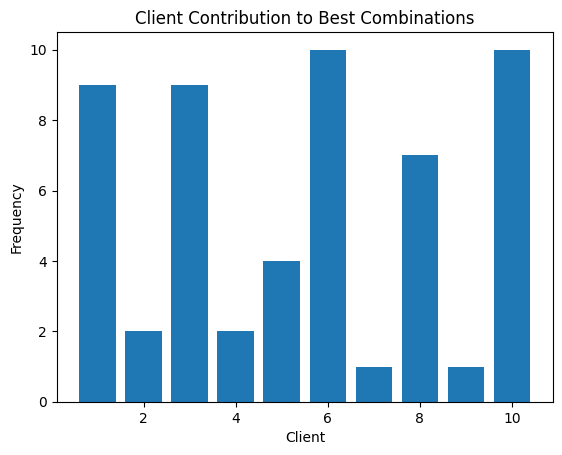

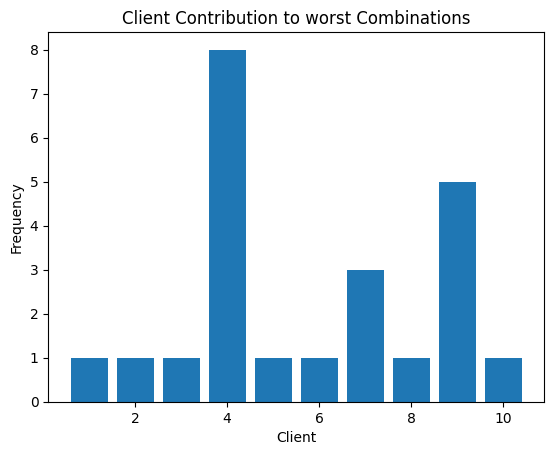

In [38]:
df_results = df_results1

best_client, worst_client = find_best_worst_clients(client_local_accuracies1)
mean_with_best, mean_without_best = calculate_global_accuracy(df_results, best_client)
mean_with_worst, mean_without_worst = calculate_global_accuracy(df_results, worst_client)
df_best_global_per_client = find_best_global_accuracy_per_client(df_results)
df_worst_global_per_client = find_worst_global_accuracy_per_client(df_results)
best_contributions = calculate_client_contributions(df_results, best=True)
worst_contributions = calculate_client_contributions(df_results, best=False)
visualize_client_contributions(best_contributions, "Client Contribution to Best Combinations")
visualize_client_contributions(worst_contributions, "Client Contribution to worst Combinations")

In [41]:
nash_df = find_nash_equilibria(df_results, n_clients=10)
nash_df

,Combination,Clients,Global Accuracy
0,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.925081


      Client  Local Accuracy  Normalized Shapley Value
5   Client 6        0.951087                  0.110895
9  Client 10        0.948370                  0.107743
7   Client 8        0.953804                  0.104271
4   Client 5        0.959239                  0.103521
0   Client 1        0.945652                  0.103194
1   Client 2        0.942935                  0.100031
2   Client 3        0.967391                  0.099718
6   Client 7        0.940217                  0.097930
8   Client 9        0.929348                  0.092750
3   Client 4        0.823045                  0.079948


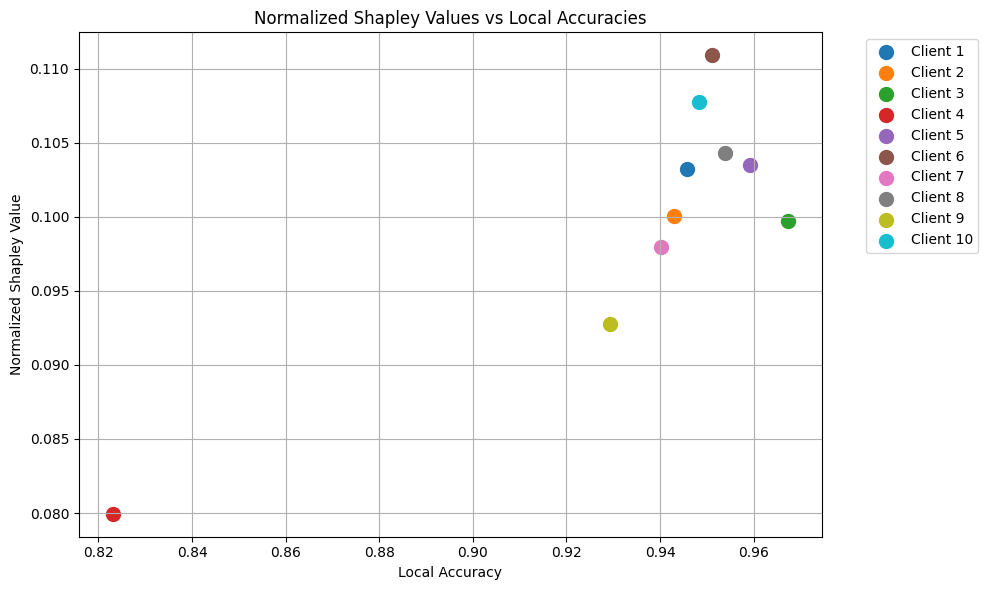

In [42]:
result = compute_and_visualize_shapley_values(
    df_results,
    client_local_accuracies1 ,
    n_clients=10
)

Client 1: Mean With Client = 0.92, Mean Without Client = 0.92
Client 2: Mean With Client = 0.92, Mean Without Client = 0.92
Client 3: Mean With Client = 0.92, Mean Without Client = 0.92
Client 4: Mean With Client = 0.92, Mean Without Client = 0.92
Client 5: Mean With Client = 0.92, Mean Without Client = 0.92
Client 6: Mean With Client = 0.92, Mean Without Client = 0.91
Client 7: Mean With Client = 0.92, Mean Without Client = 0.92
Client 8: Mean With Client = 0.92, Mean Without Client = 0.92
Client 9: Mean With Client = 0.92, Mean Without Client = 0.92
Client 10: Mean With Client = 0.92, Mean Without Client = 0.92


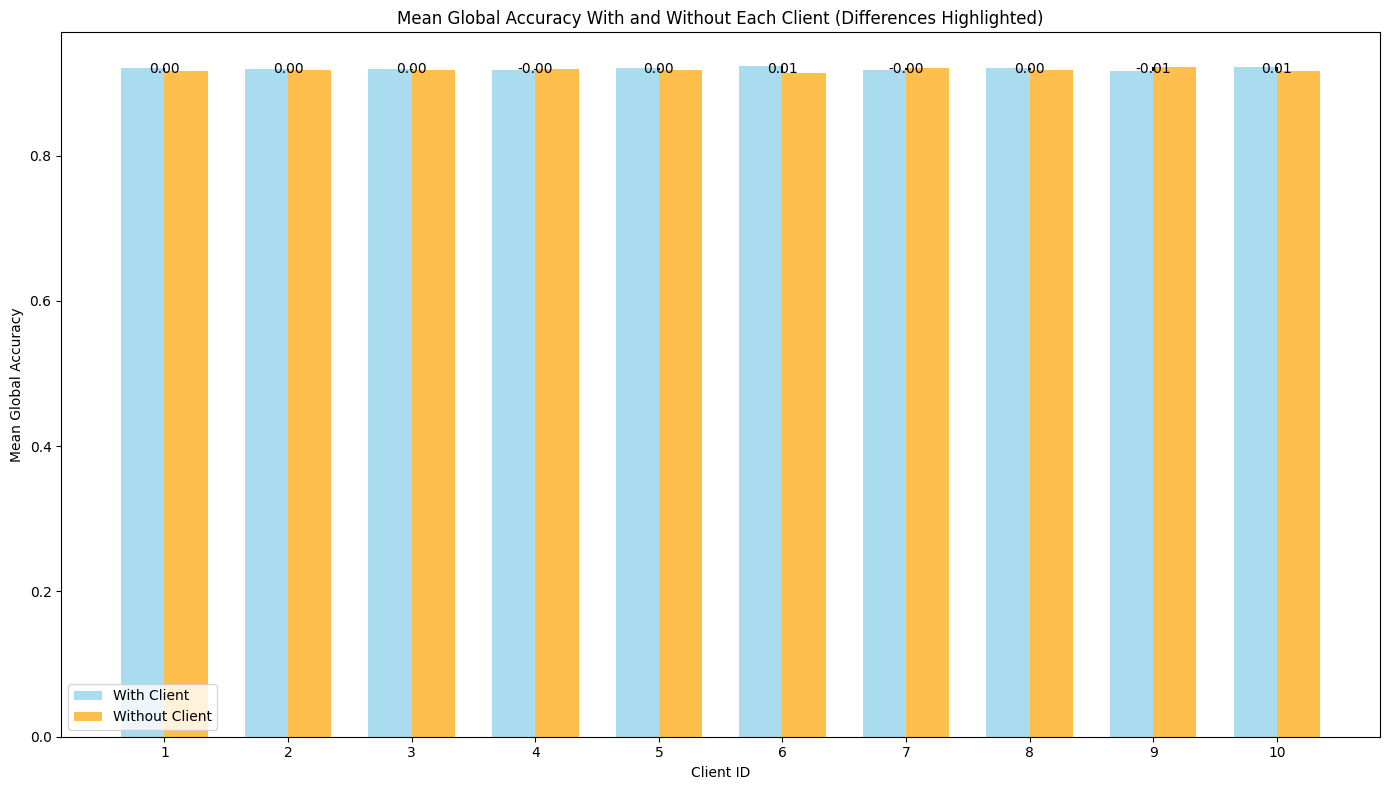

In [43]:
n_clients = 10  
results = calculate_and_plot_global_accuracy_with_differences(df_results, n_clients)

In [44]:
# Call the function
df_results2, corrupt_client_indices , client_local_accuracies2, client_global_accuracies2 = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=5,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)
df_top_results = df_results2.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

Corrupted client indices: [10  4  6  5  9]


,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
390,0110000111,"[1, 2, 3, 8, 9]",0.927253,0.903366,0.893594,0.892508,0.627579,0.666667,0.668838,0.900109,0.908795,0.677524,0.692725
902,1110000111,"[1, 2, 3, 8, 9, 10]",0.926167,0.903366,0.893594,0.892508,0.627579,0.666667,0.668838,0.900109,0.908795,0.677524,0.692725
430,0110101111,"[1, 2, 3, 4, 6, 8, 9]",0.926167,0.903366,0.893594,0.892508,0.627579,0.666667,0.668838,0.900109,0.908795,0.677524,0.692725
134,0010000111,"[1, 2, 3, 8]",0.926167,0.903366,0.893594,0.892508,0.627579,0.666667,0.668838,0.900109,0.908795,0.677524,0.692725
678,1010100111,"[1, 2, 3, 6, 8, 10]",0.926167,0.903366,0.893594,0.892508,0.627579,0.666667,0.668838,0.900109,0.908795,0.677524,0.692725


Best Client: 3, Worst Client: 9
Statistics of Global Accuracy with Client 3:
  Mean: 0.9103046959826275
  Std Dev: 0.009009522086444562
  Min: 0.8740499457111836
  Max: 0.9272529858849077

Statistics of Global Accuracy without Client 3:
  Mean: 0.8924380246945058
  Std Dev: 0.05556751054565358
  Min: 0.6275787187839305
  Max: 0.9229098805646037
Statistics of Global Accuracy with Client 9:
  Mean: 0.9012473703854506
  Std Dev: 0.04085745678638523
  Min: 0.6623235613463626
  Max: 0.9272529858849077

Statistics of Global Accuracy without Client 9:
  Mean: 0.9015130749993093
  Std Dev: 0.040700328684519775
  Min: 0.6275787187839305
  Max: 0.9261672095548317
Best Global Accuracy per Client:
    Client  Best Global Accuracy       Best Combination
0       1              0.927253        [1, 2, 3, 8, 9]
1       2              0.927253        [1, 2, 3, 8, 9]
2       3              0.927253        [1, 2, 3, 8, 9]
3       4              0.926167  [1, 2, 3, 4, 6, 8, 9]
4       5              0.9250

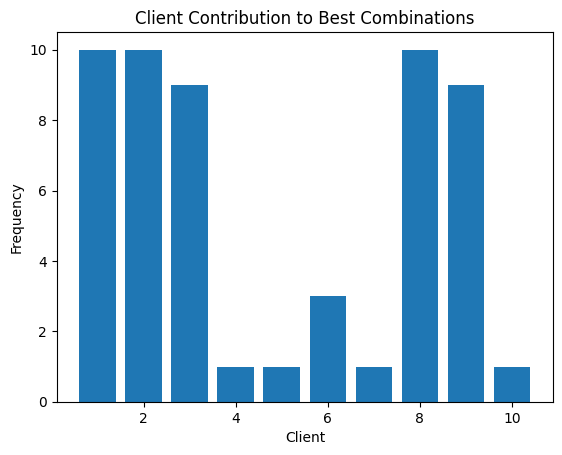

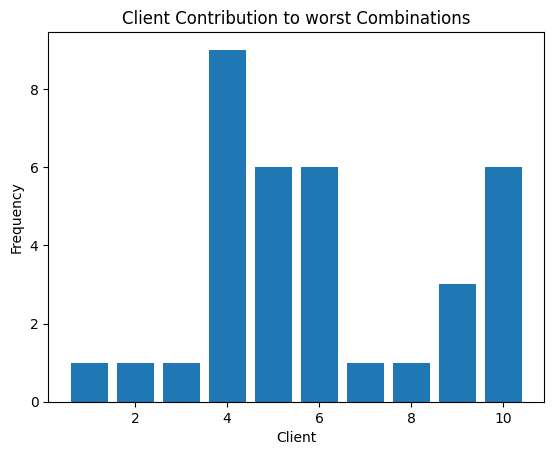

In [45]:
df_results = df_results2

best_client, worst_client = find_best_worst_clients(client_local_accuracies2)
mean_with_best, mean_without_best = calculate_global_accuracy(df_results, best_client)
mean_with_worst, mean_without_worst = calculate_global_accuracy(df_results, worst_client)
df_best_global_per_client = find_best_global_accuracy_per_client(df_results)
df_worst_global_per_client = find_worst_global_accuracy_per_client(df_results)
best_contributions = calculate_client_contributions(df_results, best=True)
worst_contributions = calculate_client_contributions(df_results, best=False)
visualize_client_contributions(best_contributions, "Client Contribution to Best Combinations")
visualize_client_contributions(worst_contributions, "Client Contribution to worst Combinations")


In [46]:
df_results = df_results2
nash_df = find_nash_equilibria(df_results, n_clients=10)
nash_df

,Combination,Clients,Global Accuracy
0,0100111000,"[4, 5, 6, 9]",0.688382
1,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.917481


      Client  Local Accuracy  Normalized Shapley Value
0   Client 1        0.945652                  0.132555
7   Client 8        0.953804                  0.131202
1   Client 2        0.942935                  0.127221
2   Client 3        0.967391                  0.125456
6   Client 7        0.940217                  0.124722
9  Client 10        0.766816                  0.074654
8   Client 9        0.754717                  0.074581
5   Client 6        0.806763                  0.072447
4   Client 5        0.766667                  0.070882
3   Client 4        0.763393                  0.066281


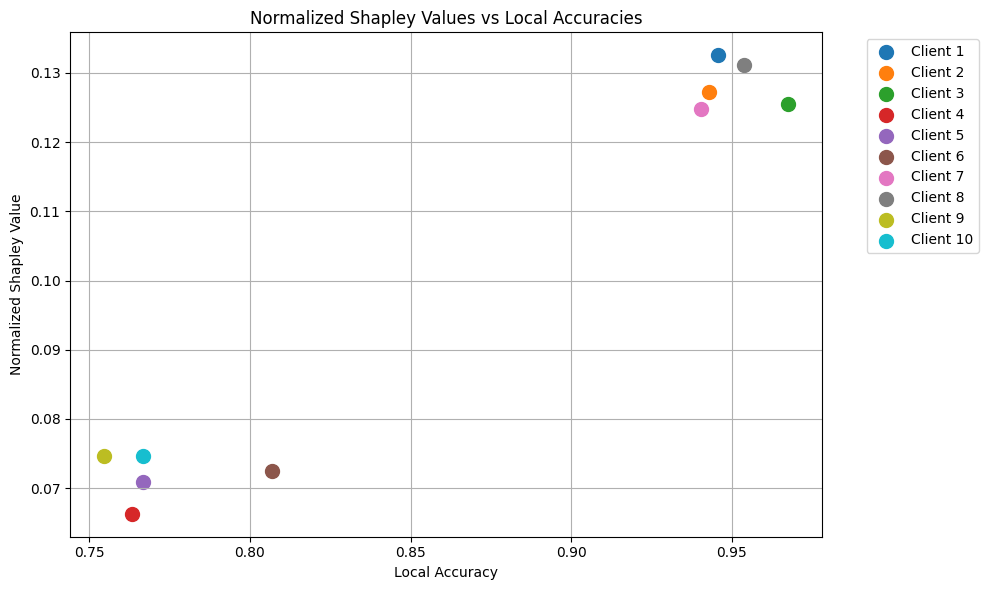

In [47]:
result = compute_and_visualize_shapley_values(
    df_results,
    client_local_accuracies2 ,
    n_clients=10
)

Client 1: Mean With Client = 0.91, Mean Without Client = 0.89
Client 2: Mean With Client = 0.91, Mean Without Client = 0.89
Client 3: Mean With Client = 0.91, Mean Without Client = 0.89
Client 4: Mean With Client = 0.90, Mean Without Client = 0.90
Client 5: Mean With Client = 0.90, Mean Without Client = 0.90
Client 6: Mean With Client = 0.90, Mean Without Client = 0.90
Client 7: Mean With Client = 0.91, Mean Without Client = 0.89
Client 8: Mean With Client = 0.91, Mean Without Client = 0.89
Client 9: Mean With Client = 0.90, Mean Without Client = 0.90
Client 10: Mean With Client = 0.90, Mean Without Client = 0.90


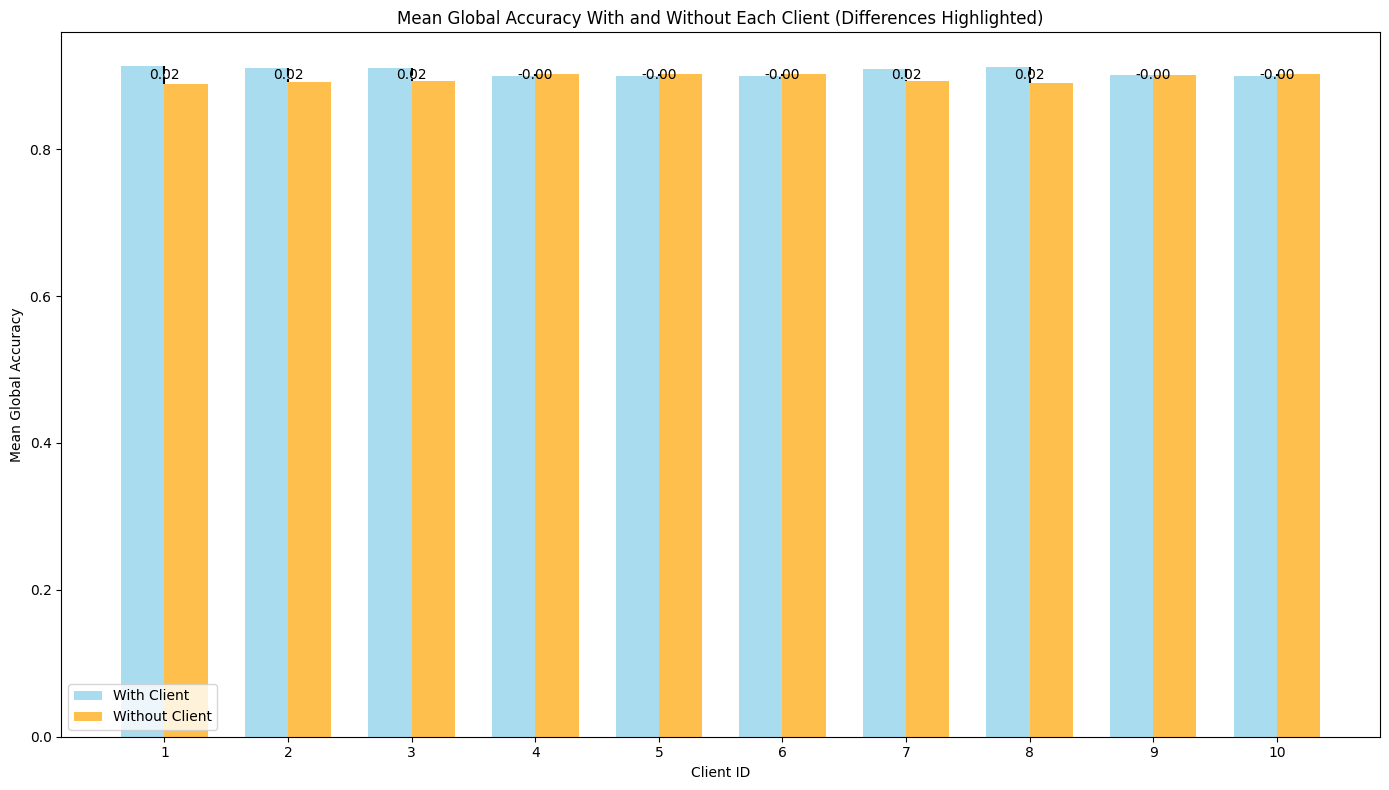

In [48]:

n_clients = 10  
results = calculate_and_plot_global_accuracy_with_differences(df_results, n_clients)

In [49]:
# Call the function
df_results3, corrupt_client_indices , client_local_accuracies3  , client_global_accuracies3 = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=7,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)
df_top_results = df_results3.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

Corrupted client indices: [ 7  9  4  3 10  2  6]


,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy,Client 10 Accuracy
400,0110010001,"[1, 5, 8, 9]",0.920738,0.903366,0.713355,0.728556,0.640608,0.909881,0.689468,0.69164,0.908795,0.763301,0.758958
463,0111010000,"[5, 7, 8, 9]",0.919653,0.903366,0.713355,0.728556,0.640608,0.909881,0.689468,0.69164,0.908795,0.763301,0.758958
144,0010010001,"[1, 5, 8]",0.919653,0.903366,0.713355,0.728556,0.640608,0.909881,0.689468,0.69164,0.908795,0.763301,0.758958
436,0110110101,"[1, 3, 5, 6, 8, 9]",0.919653,0.903366,0.713355,0.728556,0.640608,0.909881,0.689468,0.69164,0.908795,0.763301,0.758958
932,1110100101,"[1, 3, 6, 8, 9, 10]",0.919653,0.903366,0.713355,0.728556,0.640608,0.909881,0.689468,0.69164,0.908795,0.763301,0.758958


Best Client: 5, Worst Client: 4
Statistics of Global Accuracy with Client 5:
  Mean: 0.9076517542073832
  Std Dev: 0.006023665101763448
  Min: 0.8914223669923995
  Max: 0.9207383279044516

Statistics of Global Accuracy without Client 5:
  Mean: 0.8679071289396576
  Std Dev: 0.06227594667007937
  Min: 0.6406080347448425
  Max: 0.9196525515743756
Statistics of Global Accuracy with Client 4:
  Mean: 0.8848992263843648
  Std Dev: 0.05200971663751999
  Min: 0.6406080347448425
  Max: 0.9185667752442996

Statistics of Global Accuracy without Client 4:
  Mean: 0.8907041822574373
  Std Dev: 0.04449242872111449
  Min: 0.6894679695982627
  Max: 0.9207383279044516
Best Global Accuracy per Client:
    Client  Best Global Accuracy     Best Combination
0       1              0.920738         [1, 5, 8, 9]
1       2              0.914224         [2, 5, 8, 9]
2       3              0.919653   [1, 3, 5, 6, 8, 9]
3       4              0.918567         [1, 4, 5, 8]
4       5              0.920738         

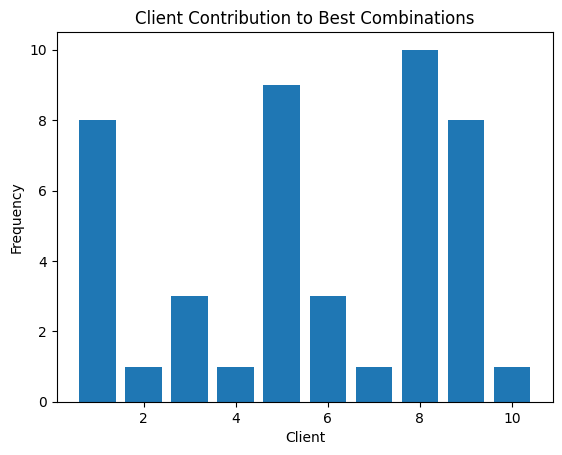

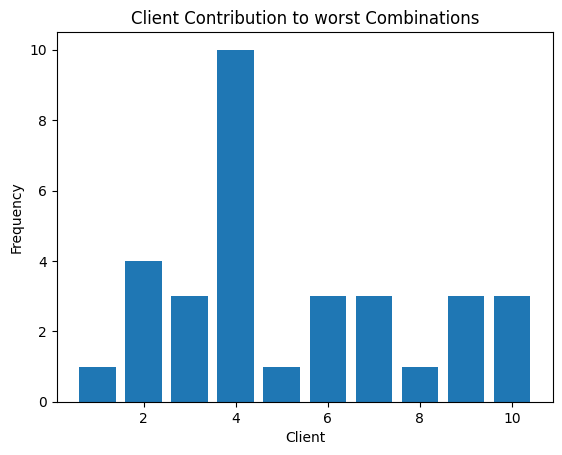

In [50]:
df_results = df_results3

best_client, worst_client = find_best_worst_clients(client_local_accuracies3)
mean_with_best, mean_without_best = calculate_global_accuracy(df_results, best_client)
mean_with_worst, mean_without_worst = calculate_global_accuracy(df_results, worst_client)
df_best_global_per_client = find_best_global_accuracy_per_client(df_results)
df_worst_global_per_client = find_worst_global_accuracy_per_client(df_results)
best_contributions = calculate_client_contributions(df_results, best=True)
worst_contributions = calculate_client_contributions(df_results, best=False)
visualize_client_contributions(best_contributions, "Client Contribution to Best Combinations")
visualize_client_contributions(worst_contributions, "Client Contribution to worst Combinations")

In [51]:
df_results = df_results3
nash_df = find_nash_equilibria(df_results, n_clients=10)
nash_df

,Combination,Clients,Global Accuracy
0,1101101110,"[2, 3, 4, 6, 7, 9, 10]",0.786102


      Client  Local Accuracy  Normalized Shapley Value
7   Client 8        0.953804                  0.147468
4   Client 5        0.959239                  0.144969
0   Client 1        0.945652                  0.142823
8   Client 9        0.793860                  0.091502
9  Client 10        0.787611                  0.089047
2   Client 3        0.850242                  0.087450
1   Client 2        0.798206                  0.078322
5   Client 6        0.786364                  0.076802
6   Client 7        0.806452                  0.076598
3   Client 4        0.778761                  0.065019


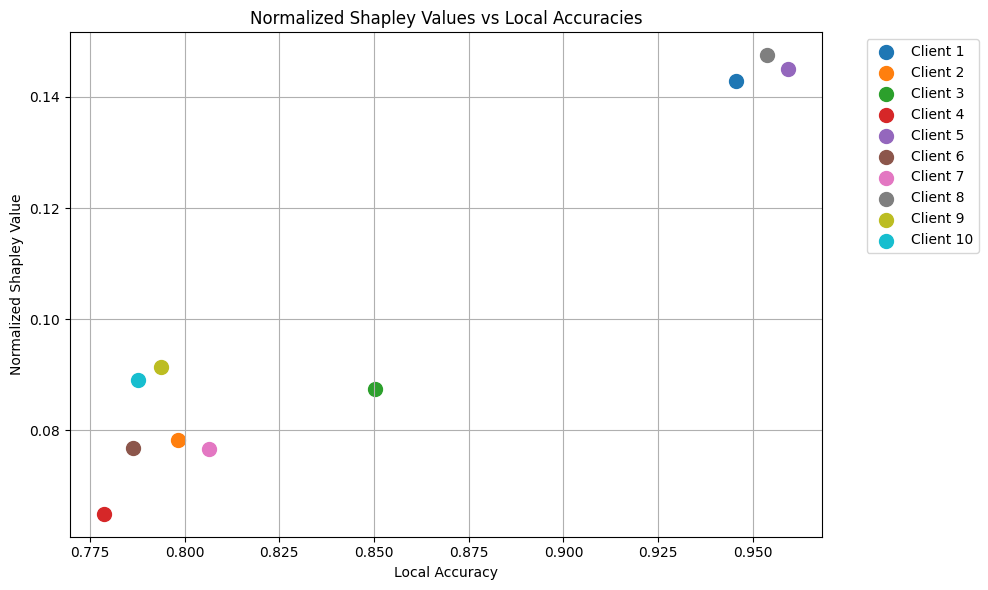

In [52]:
result = compute_and_visualize_shapley_values(
    df_results,
    client_local_accuracies3 ,
    n_clients=10
)

Client 1: Mean With Client = 0.91, Mean Without Client = 0.87
Client 2: Mean With Client = 0.89, Mean Without Client = 0.89
Client 3: Mean With Client = 0.89, Mean Without Client = 0.89
Client 4: Mean With Client = 0.88, Mean Without Client = 0.89
Client 5: Mean With Client = 0.91, Mean Without Client = 0.87
Client 6: Mean With Client = 0.89, Mean Without Client = 0.89
Client 7: Mean With Client = 0.89, Mean Without Client = 0.89
Client 8: Mean With Client = 0.91, Mean Without Client = 0.87
Client 9: Mean With Client = 0.89, Mean Without Client = 0.89
Client 10: Mean With Client = 0.89, Mean Without Client = 0.89


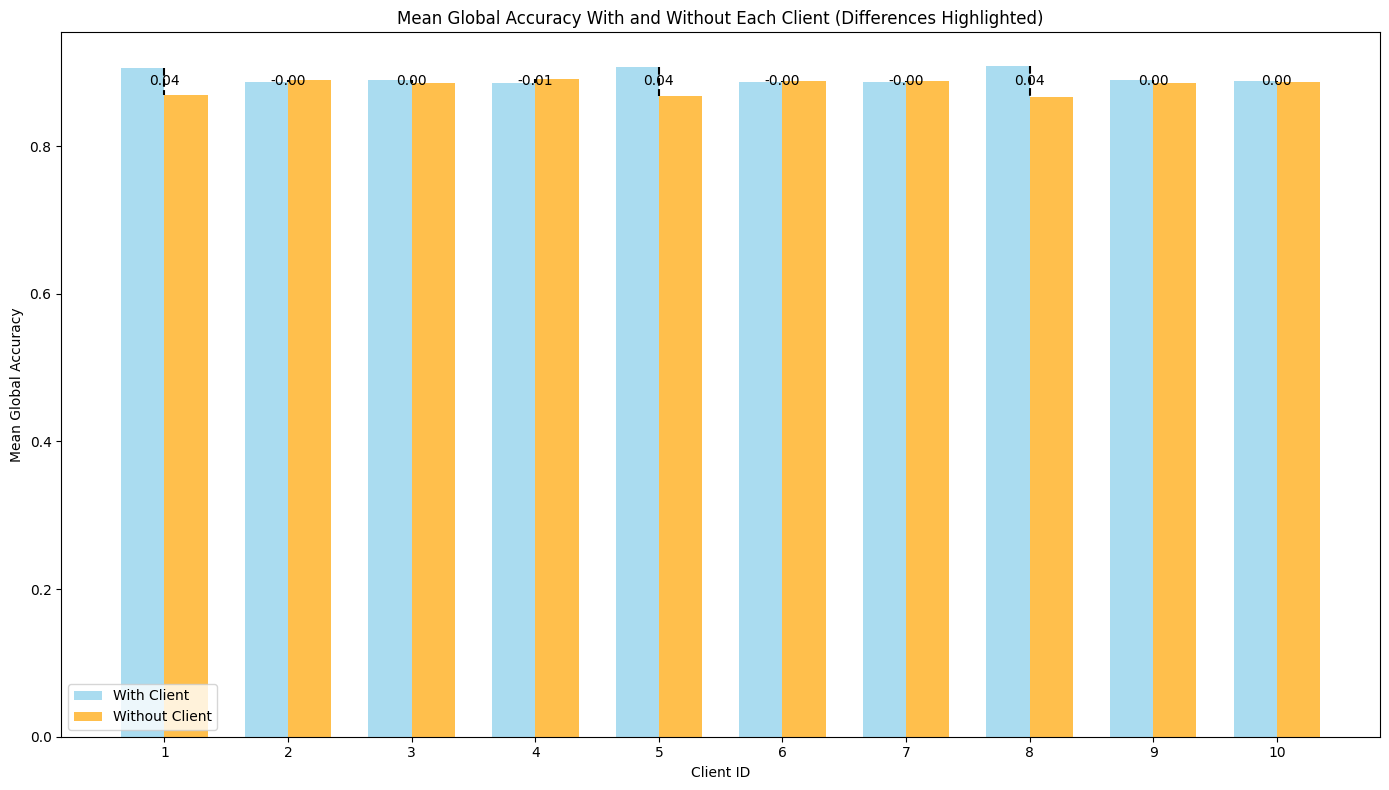

In [53]:
n_clients = 10  
results = calculate_and_plot_global_accuracy_with_differences(df_results, n_clients)

### Run for 1 to 9 Number of corrupted clients

In [54]:
results_all = []

# Loop over n_corrupt_clients from 1 to 9
for n_corrupt_clients in range(1, 10):  
    print(f"Running federated learning with {n_corrupt_clients} corrupt clients...")

    df_results, corrupt_client_indices, client_local_accuracies, client_global_accuracies = run_federated_learning(
        partitions=partitions,
        n_clients=n_clients,
        n_corrupt_clients=n_corrupt_clients,  # Update the number of corrupted clints
        random_seed=42,
        shuffle=True,
        max_iter=10
    )


    df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
    

    results_all.append({
        'n_corrupt_clients': n_corrupt_clients,
        'top_results': df_top_results
    })
    

    df_results = df_results


    best_client, worst_client = find_best_worst_clients(client_local_accuracies)


    nash_df = find_nash_equilibria(df_results, n_clients=n_clients)
    
    print(f"Nash Equilibria for {n_corrupt_clients} corrupt clients:")
    print(nash_df.head())
    results_all[-1]['nash_equilibria'] = nash_df


df_all_results = pd.DataFrame(results_all)

df_all_results.to_csv('federated_learning_results.csv', index=False)


Running federated learning with 1 corrupt clients...
Corrupted client indices: [5]
Best Client: 3, Worst Client: 9
Nash Equilibria for 1 corrupt clients:
  Combination                          Clients  Global Accuracy
0  1111111111  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]         0.927253
Running federated learning with 2 corrupt clients...
Corrupted client indices: [ 8 10]
Best Client: 3, Worst Client: 9
Nash Equilibria for 2 corrupt clients:
  Combination                          Clients  Global Accuracy
0  1111111111  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]         0.917481
Running federated learning with 3 corrupt clients...
Corrupted client indices: [4 3 2]
Best Client: 3, Worst Client: 9
Nash Equilibria for 3 corrupt clients:
  Combination                          Clients  Global Accuracy
0  0000001010                           [2, 4]         0.635179
1  0101001111               [1, 2, 3, 4, 7, 9]         0.903366
2  1111111111  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]         0.921824
Running federated 

### Conclusion

The analysis of Nash equilibria across different numbers of corrupted clients reveals some interesting trends:

- **Fewer than half of the clients are corrupted:** When the number of corrupted clients is small (e.g., 1 to 5 out of 10 clients), the Nash equilibria are less predictable. In these cases, the equilibrium often involves all clients joining or only some of the corrupted clients participating. For instance:
  - With 1 or 2 corrupted clients, the equilibrium always shows all clients participating, as seen with combinations like `1111111111`.
  - With 3 to 5 corrupted clients, the equilibria are more varied, showing a mix of full participation and some corrupted clients joining. For example, with 3 corrupt clients, the results show a combination of full participation (`1111111111`), and others like `[2, 4]` or `[1, 2, 3, 4, 7, 9]`.

- **More than half of the clients are corrupted:** When the number of corrupted clients exceeds half of the total clients (i.e., more than 6 out of 10), the Nash equilibria results become more predictable. In these cases, the equilibria mostly consist of a mix of corrupted clients participating, as expected. For example:
  - When there are 7 or more corrupted clients, the equilibria combinations predominantly show a mixture of corrupted. This trend is clearly observed with combinations like `[3, 4, 8]` and `[2, 3, 4, 6, 7, 8, 10]` for 7 corrupted clients, and combinations like `[7, 9]` for 8 corrupted clients. (All of them were corrupted client)
  - With 9 corrupted clients, the equilibrium configuration reflects mostly a participation of the corrupted clients, as seen in the combination `1111111110`.(In this cas just the client 1 was non-corrupted and it did not join in NE)

### Summary

- With fewer corrupted clients (1 to 5), the system struggles to find a clear pattern for Nash equilibria, often showing full participation or some of the corrupted clients joining.
- With a majority of corrupted clients (6 or more), the equilibria become more consistent, with a clear mix of corrupted forming the equilibrium combinations.
